# Mobile Sales Data Analysis

This notebook contains a comprehensive analysis of mobile phone sales data, including

- Data cleaning and preparation
- Exploratory Data Analysis (EDA)
- Sales performance analysis
- Customer segmentation
- Product analysis
- Payment method analysis
- Time series analysis and correlations


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline


## 1. Data Loading and Understanding


In [2]:
# Load the dataset
df = pd.read_csv('mobile_sales.csv')

# Display the first few rows
print("Sample data:")
df.head()


Sample data:


,TransactionID,Date,MobileModel,Brand,Price,UnitsSold,TotalRevenue,CustomerAge,CustomerGender,Location,PaymentMethod
0,79397f68-61ed-4ea8-bcb2-f918d4e6c05b,2024-01-06,direction,Green Inc,1196.95,85,28002.80,32,Female,Port Erik,Online
1,4f87d114-f522-4ead-93e3-f336402df6aa,2024-04-05,right,Thomas-Thompson,1010.34,64,2378.82,55,Female,East Linda,Credit Card
2,6750b7d6-dcc5-48c5-a76a-b6fc9d540fe1,2024-02-13,summer,Sanchez-Williams,400.80,95,31322.56,57,Male,East Angelicastad,Online
3,7da7de95-f772-4cc2-bce0-b0873f98233e,2024-04-17,keep,Greer and Sons,338.60,79,31159.75,46,Other,East Kevin,Cash
4,469044af-0d60-4d87-af66-c6603e844057,2024-06-02,option,Brown and Sons,839.79,41,11523.36,38,Male,New Lindaborough,Online


In [3]:
# Understanding the dataset
print(f"Dataset shape: {df.shape}")
print("\nData types:")
df.dtypes


Dataset shape: (1000, 11)

Data types:


TransactionID      object
Date               object
MobileModel        object
Brand              object
Price             float64
UnitsSold           int64
TotalRevenue      float64
CustomerAge         int64
CustomerGender     object
Location           object
PaymentMethod      object
dtype: object

In [4]:
# Statistical summary
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Price,1000.0,807.51297,402.489878,103.32,458.0375,823.730,1157.875,1499.25
UnitsSold,1000.0,50.07400,28.616804,1.00,25.0000,51.000,75.000,99.00
TotalRevenue,1000.0,40218.44504,32715.290358,116.85,13316.0375,30860.655,60770.435,141411.84
CustomerAge,1000.0,41.14100,13.528346,18.00,29.0000,41.000,53.000,64.00


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print("Missing values analysis:")
missing_df[missing_df['Missing Values'] > 0]  # Only show columns with missing values

# If there are no missing values, print a confirmation
if missing_df['Missing Values'].sum() == 0:
    print("No missing values found in the dataset.")


Missing values analysis:
No missing values found in the dataset.


## 2. Data Cleaning and Preparation


In [6]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract additional time components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['MonthName'] = df['Date'].dt.strftime('%b')

# Check for data validation issues - verify TotalRevenue calculation
df['CalculatedRevenue'] = df['Price'] * df['UnitsSold']
revenue_mismatch = (abs(df['TotalRevenue'] - df['CalculatedRevenue']) > 1).sum()

print(f"Number of records with revenue calculation mismatch: {revenue_mismatch}")

# Create a copy of the dataframe for the cleaned data
df_clean = df.copy()

# If there are mismatches, correct the TotalRevenue
if revenue_mismatch > 0:
    df_clean['TotalRevenue'] = df_clean['CalculatedRevenue']
    
# Show the first few rows of the cleaned dataframe
df_clean.head()


Number of records with revenue calculation mismatch: 1000


,TransactionID,Date,MobileModel,Brand,Price,UnitsSold,TotalRevenue,CustomerAge,CustomerGender,Location,PaymentMethod,Year,Month,Quarter,MonthName,CalculatedRevenue
0,79397f68-61ed-4ea8-bcb2-f918d4e6c05b,2024-01-06,direction,Green Inc,1196.95,85,101740.75,32,Female,Port Erik,Online,2024,1,1,Jan,101740.75
1,4f87d114-f522-4ead-93e3-f336402df6aa,2024-04-05,right,Thomas-Thompson,1010.34,64,64661.76,55,Female,East Linda,Credit Card,2024,4,2,Apr,64661.76
2,6750b7d6-dcc5-48c5-a76a-b6fc9d540fe1,2024-02-13,summer,Sanchez-Williams,400.80,95,38076.00,57,Male,East Angelicastad,Online,2024,2,1,Feb,38076.00
3,7da7de95-f772-4cc2-bce0-b0873f98233e,2024-04-17,keep,Greer and Sons,338.60,79,26749.40,46,Other,East Kevin,Cash,2024,4,2,Apr,26749.40
4,469044af-0d60-4d87-af66-c6603e844057,2024-06-02,option,Brown and Sons,839.79,41,34431.39,38,Male,New Lindaborough,Online,2024,6,2,Jun,34431.39


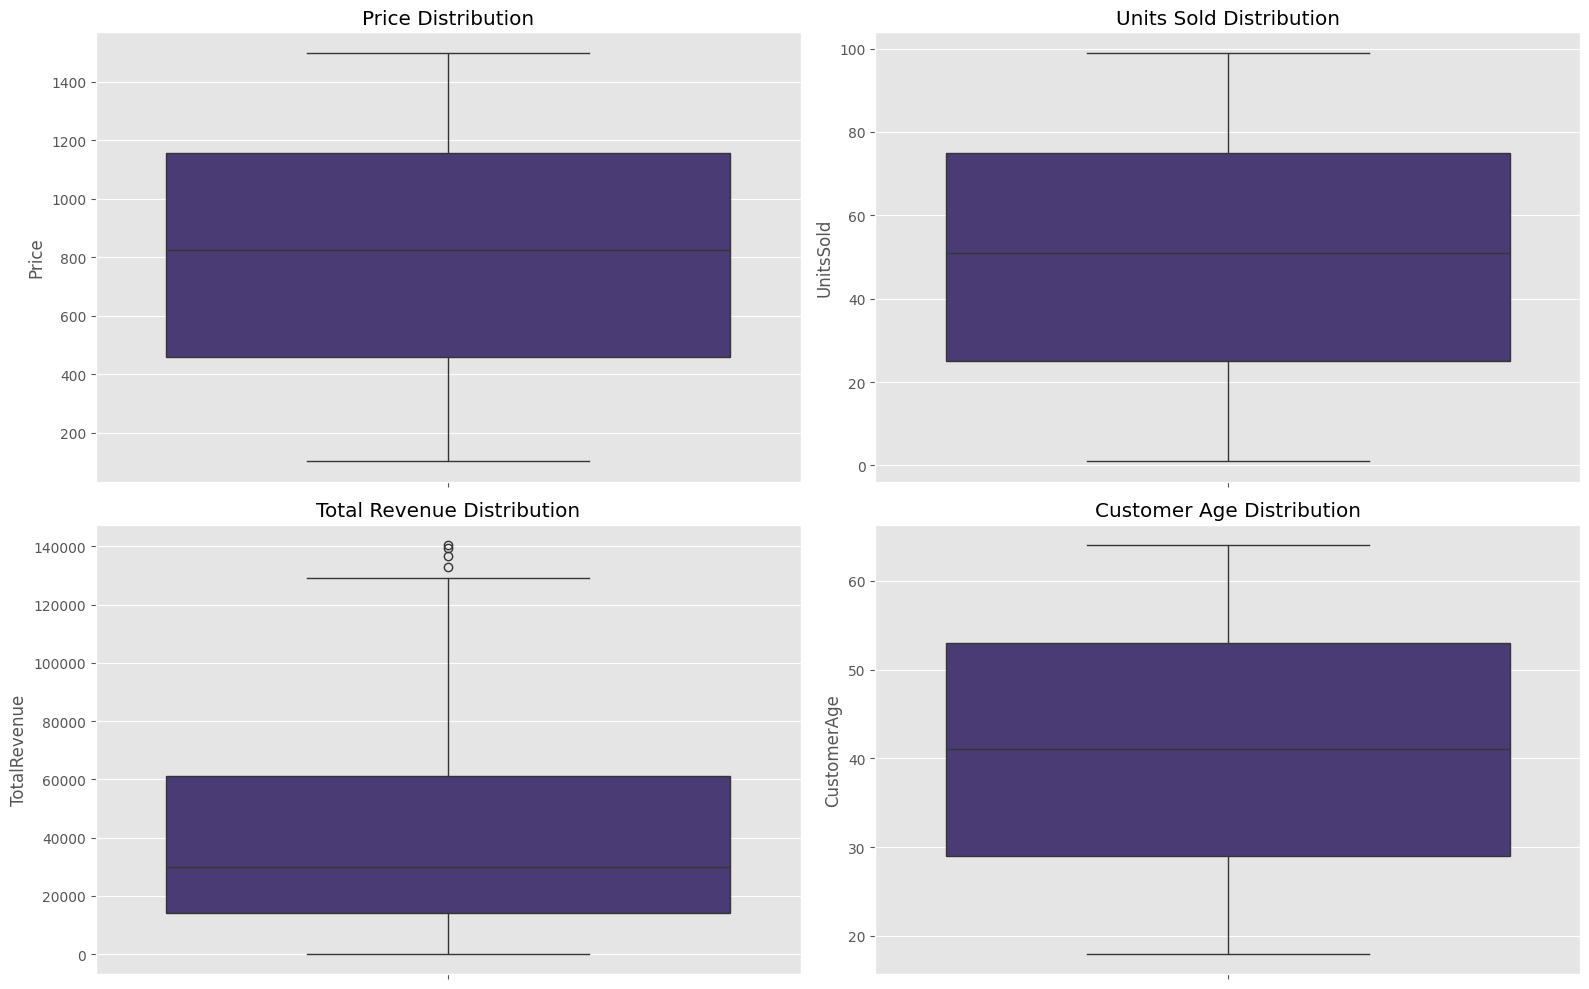

Price: 0 outliers identified (bounds: -591.72 to 2207.63)
UnitsSold: 0 outliers identified (bounds: -50.00 to 150.00)
TotalRevenue: 4 outliers identified (bounds: -56745.78 to 131907.41)
CustomerAge: 0 outliers identified (bounds: -7.00 to 89.00)


In [7]:
# Check for outliers using boxplots
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df_clean['Price'])
plt.title('Price Distribution')

plt.subplot(2, 2, 2)
sns.boxplot(y=df_clean['UnitsSold'])
plt.title('Units Sold Distribution')

plt.subplot(2, 2, 3)
sns.boxplot(y=df_clean['TotalRevenue'])
plt.title('Total Revenue Distribution')

plt.subplot(2, 2, 4)
sns.boxplot(y=df_clean['CustomerAge'])
plt.title('Customer Age Distribution')

plt.tight_layout()
plt.show()

# Identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Check for outliers in key numeric columns
columns_to_check = ['Price', 'UnitsSold', 'TotalRevenue', 'CustomerAge']

for col in columns_to_check:
    outliers_count, lower, upper = identify_outliers(df_clean, col)
    print(f"{col}: {outliers_count} outliers identified (bounds: {lower:.2f} to {upper:.2f})")


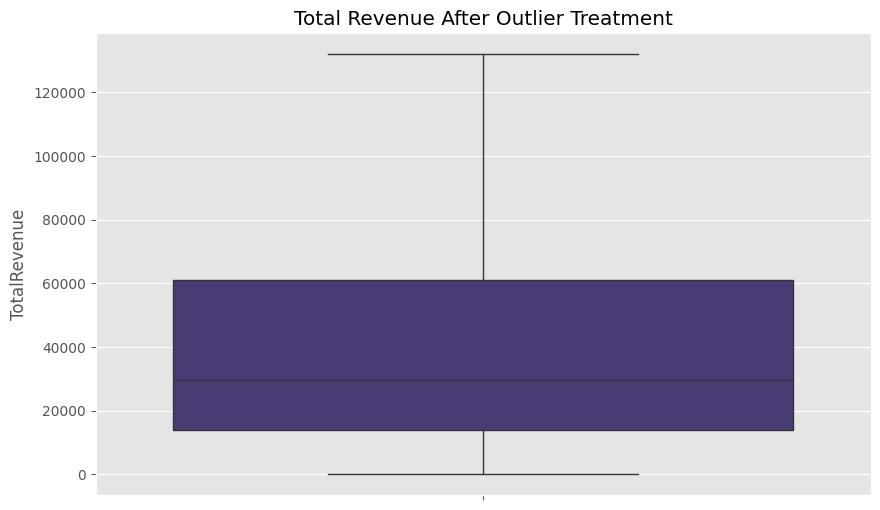

,Price,UnitsSold,TotalRevenue,CustomerAge
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,807.512970,50.074000,39918.322215,41.141000
std,402.489878,28.616804,32204.507306,13.528346
min,103.320000,1.000000,104.990000,18.000000
25%,458.037500,25.000000,13999.162500,29.000000
50%,823.730000,51.000000,29783.550000,41.000000
75%,1157.875000,75.000000,61162.460000,53.000000
max,1499.250000,99.000000,131907.406250,64.000000


In [8]:
# Handle outliers - we'll cap the extreme values instead of removing them
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Cap outliers in TotalRevenue which is the most important metric
df_clean = cap_outliers(df_clean, 'TotalRevenue')

# Verify the outliers have been handled
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_clean['TotalRevenue'])
plt.title('Total Revenue After Outlier Treatment')
plt.show()

# Describe the cleaned data
df_clean[['Price', 'UnitsSold', 'TotalRevenue', 'CustomerAge']].describe()


## 3. Exploratory Data Analysis (EDA)

### 3.1 Sales Performance Analysis


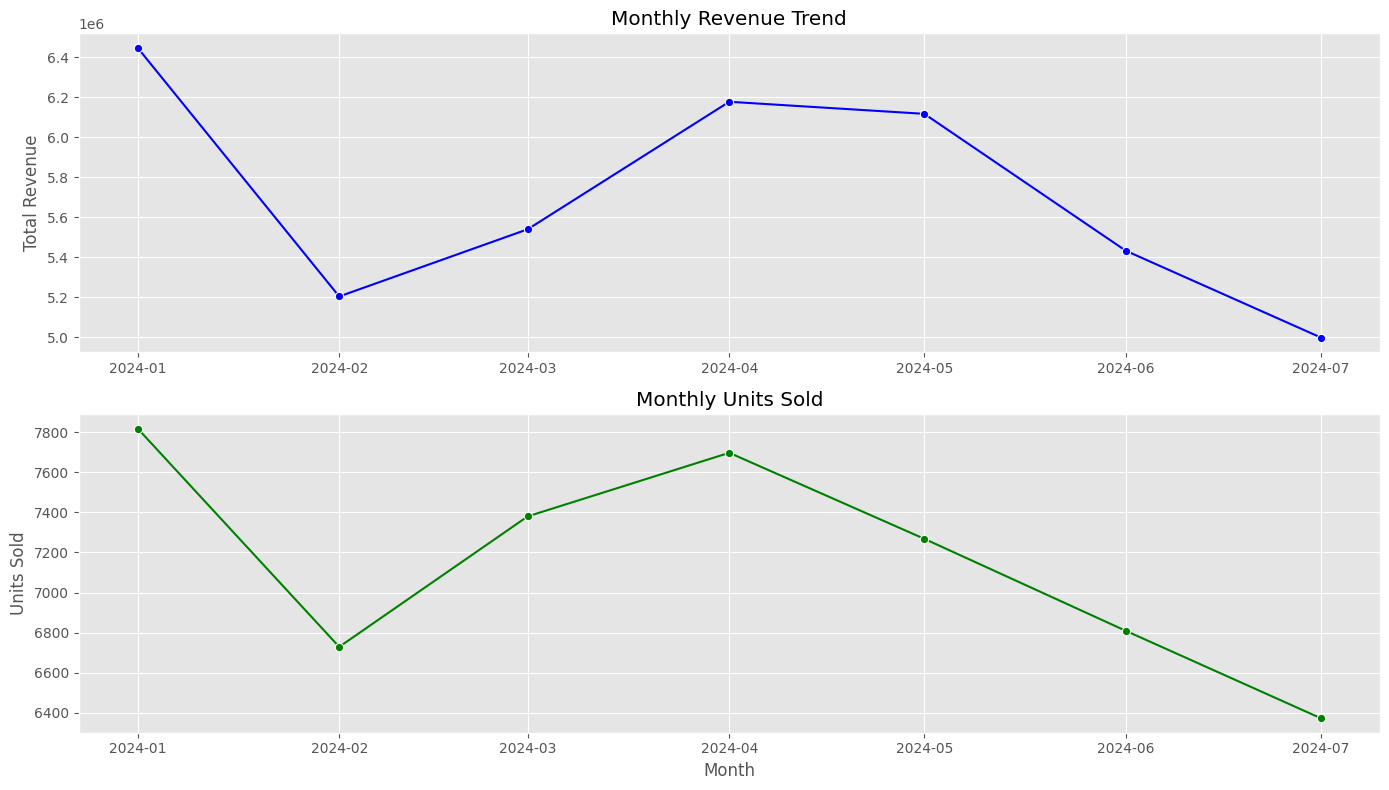

<Figure size 1400x600 with 0 Axes>

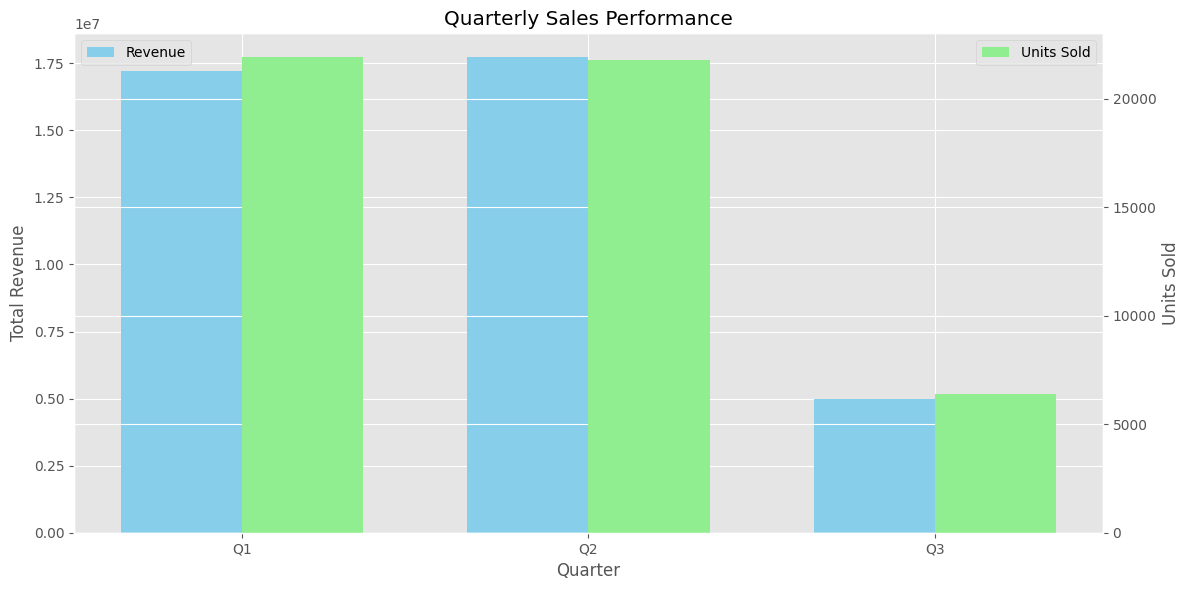

In [ ]:
# Monthly sales trends
monthly_sales = df_clean.groupby(['Year', 'Month', 'MonthName']).agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count'  # Count of transactions
}).reset_index()

monthly_sales = monthly_sales.rename(columns={'TransactionID': 'Transactions'})
monthly_sales = monthly_sales.sort_values(['Year', 'Month'])

# Create a proper time series for plotting
monthly_sales['Date'] = monthly_sales.apply(lambda x: f"{int(x['Year'])}-{int(x['Month']):02d}-01", axis=1)
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Date'])

# Plot monthly revenue and units sold
plt.figure(figsize=(14, 8))

# Revenue plot
ax1 = plt.subplot(211)
sns.lineplot(x='Date', y='TotalRevenue', data=monthly_sales, marker='o', color='blue', ax=ax1)
ax1.set_title('Monthly Revenue Trend')
ax1.set_xlabel('')
ax1.set_ylabel('Total Revenue')

# Units sold plot
ax2 = plt.subplot(212)
sns.lineplot(x='Date', y='UnitsSold', data=monthly_sales, marker='o', color='green', ax=ax2)
ax2.set_title('Monthly Units Sold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Units Sold')

plt.tight_layout()
plt.show()

# Quarterly sales trends
quarterly_sales = df_clean.groupby(['Year', 'Quarter']).agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count'  # Count of transactions
}).reset_index()

quarterly_sales = quarterly_sales.rename(columns={'TransactionID': 'Transactions'})

# Create labels for quarters
quarterly_sales['QuarterLabel'] = quarterly_sales.apply(lambda x: f"Q{int(x['Quarter'])}", axis=1)

# Plot quarterly revenue and units sold
plt.figure(figsize=(14, 6))
quarters = quarterly_sales['QuarterLabel'].tolist()

x = np.arange(len(quarters))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, quarterly_sales['TotalRevenue'], width, color='skyblue', label='Revenue')
bars2 = ax2.bar(x + width/2, quarterly_sales['UnitsSold'], width, color='lightgreen', label='Units Sold')

ax1.set_xlabel('Quarter')
ax1.set_ylabel('Total Revenue')
ax2.set_ylabel('Units Sold')
ax1.set_title('Quarterly Sales Performance')

ax1.set_xticks(x)
ax1.set_xticklabels(quarters)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


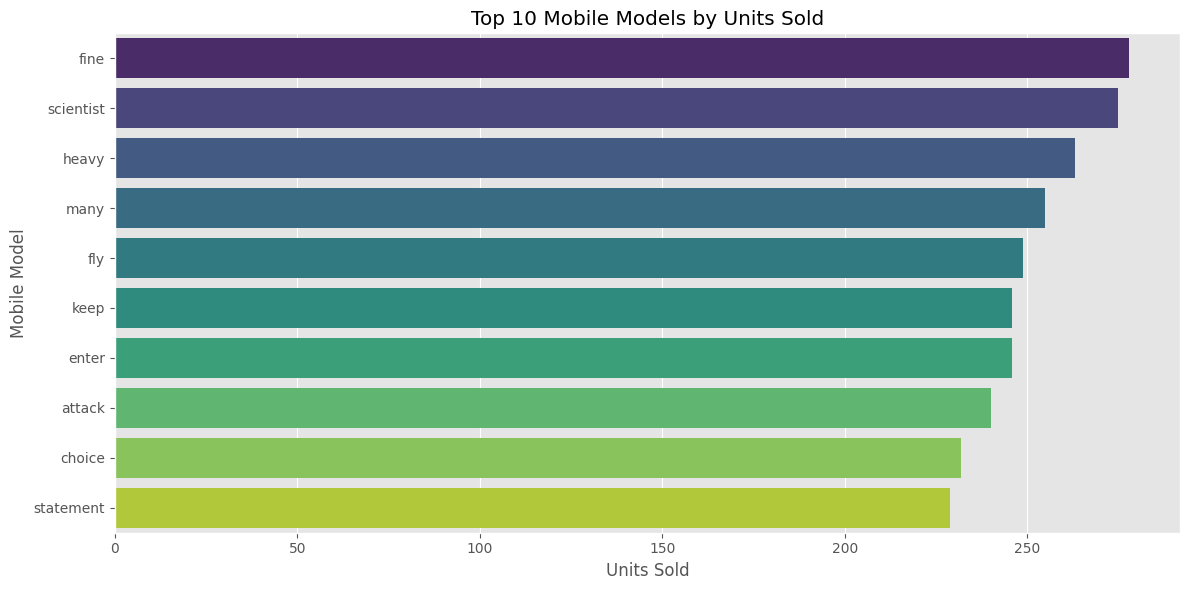

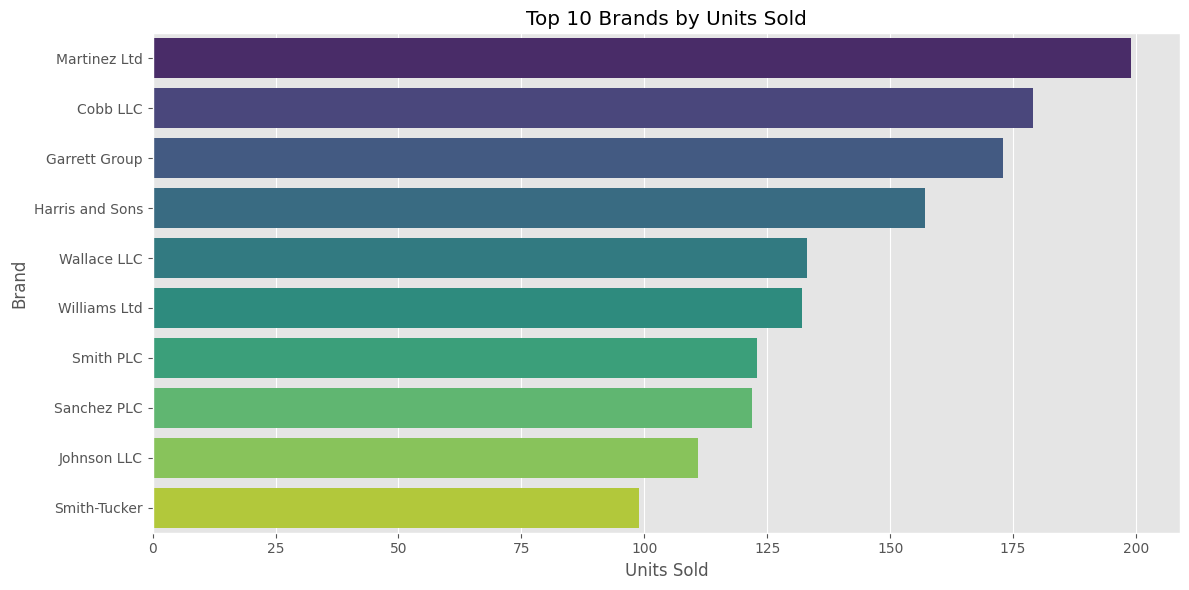

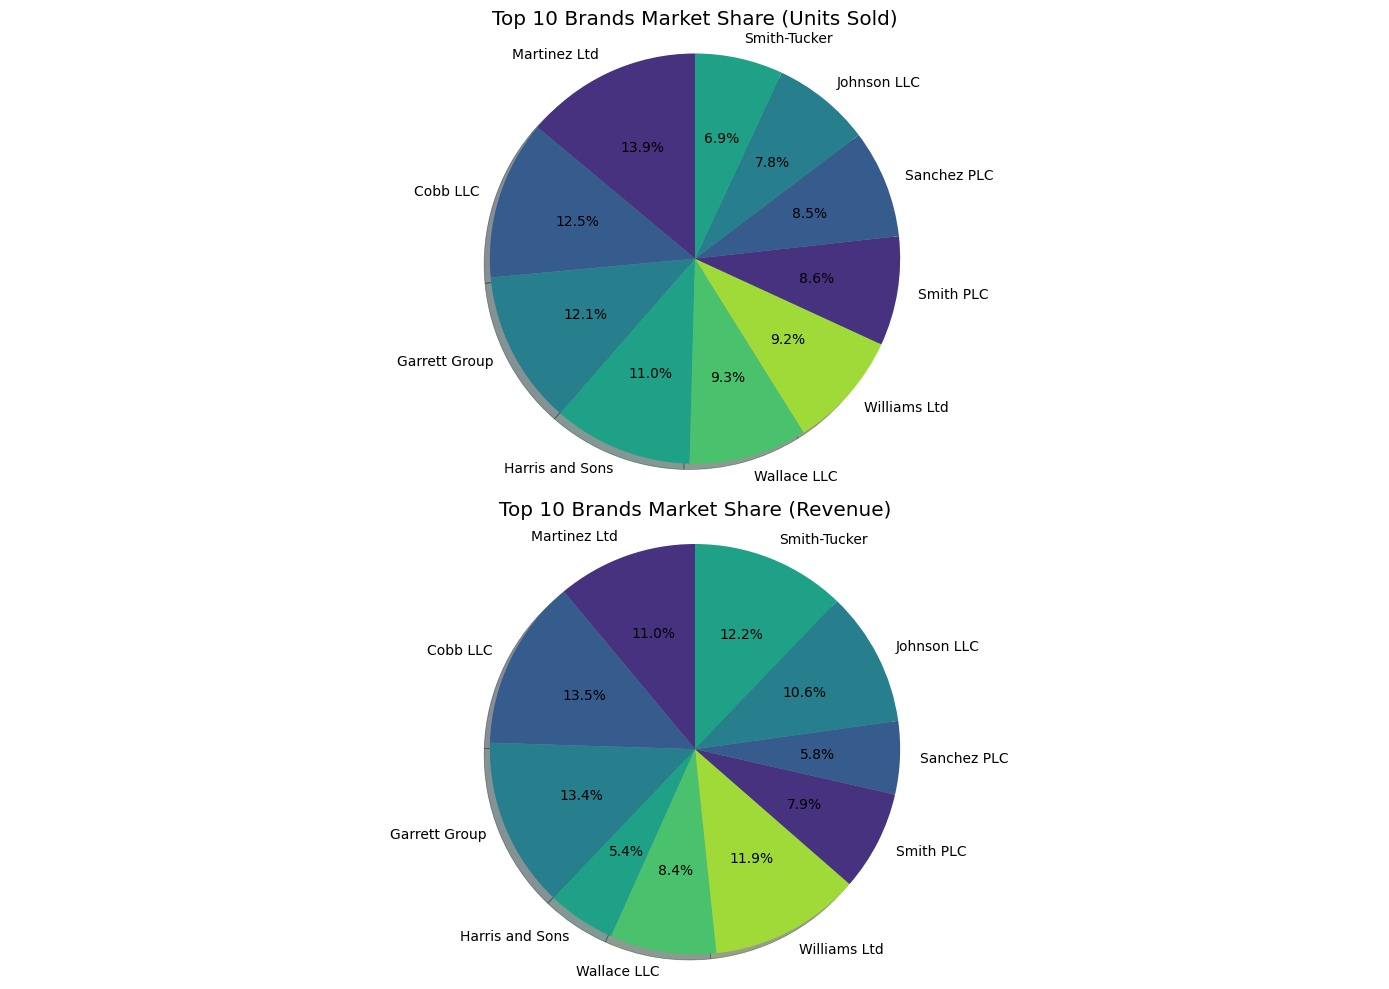

In [ ]:
# Top selling models and brands
top_models = df_clean.groupby('MobileModel').agg({
    'UnitsSold': 'sum',
    'TotalRevenue': 'sum'
}).sort_values('UnitsSold', ascending=False).head(10).reset_index()

top_brands = df_clean.groupby('Brand').agg({
    'UnitsSold': 'sum',
    'TotalRevenue': 'sum'
}).sort_values('UnitsSold', ascending=False).head(10).reset_index()

# Calculate market share by brand
total_units = df_clean['UnitsSold'].sum()
total_revenue = df_clean['TotalRevenue'].sum()

brand_market_share = df_clean.groupby('Brand').agg({
    'UnitsSold': 'sum',
    'TotalRevenue': 'sum'
}).reset_index()

brand_market_share['UnitShare'] = (brand_market_share['UnitsSold'] / total_units) * 100
brand_market_share['RevenueShare'] = (brand_market_share['TotalRevenue'] / total_revenue) * 100
brand_market_share = brand_market_share.sort_values('UnitShare', ascending=False)

# Plot top models by units sold
plt.figure(figsize=(12, 6))
sns.barplot(x='UnitsSold', y='MobileModel', data=top_models, palette='viridis')
plt.title('Top 10 Mobile Models by Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Mobile Model')
plt.tight_layout()
plt.show()

# Plot top brands by units sold
plt.figure(figsize=(12, 6))
sns.barplot(x='UnitsSold', y='Brand', data=top_brands, palette='viridis')
plt.title('Top 10 Brands by Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

# Plot market share by brand (top 10)
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
brand_market_share_top10 = brand_market_share.head(10)
plt.pie(brand_market_share_top10['UnitShare'], labels=brand_market_share_top10['Brand'], 
        autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Top 10 Brands Market Share (Units Sold)')
plt.axis('equal')

plt.subplot(2, 1, 2)
plt.pie(brand_market_share_top10['RevenueShare'], labels=brand_market_share_top10['Brand'], 
        autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Top 10 Brands Market Share (Revenue)')
plt.axis('equal')

plt.tight_layout()
plt.show()


### 3.2 Customer Analysis


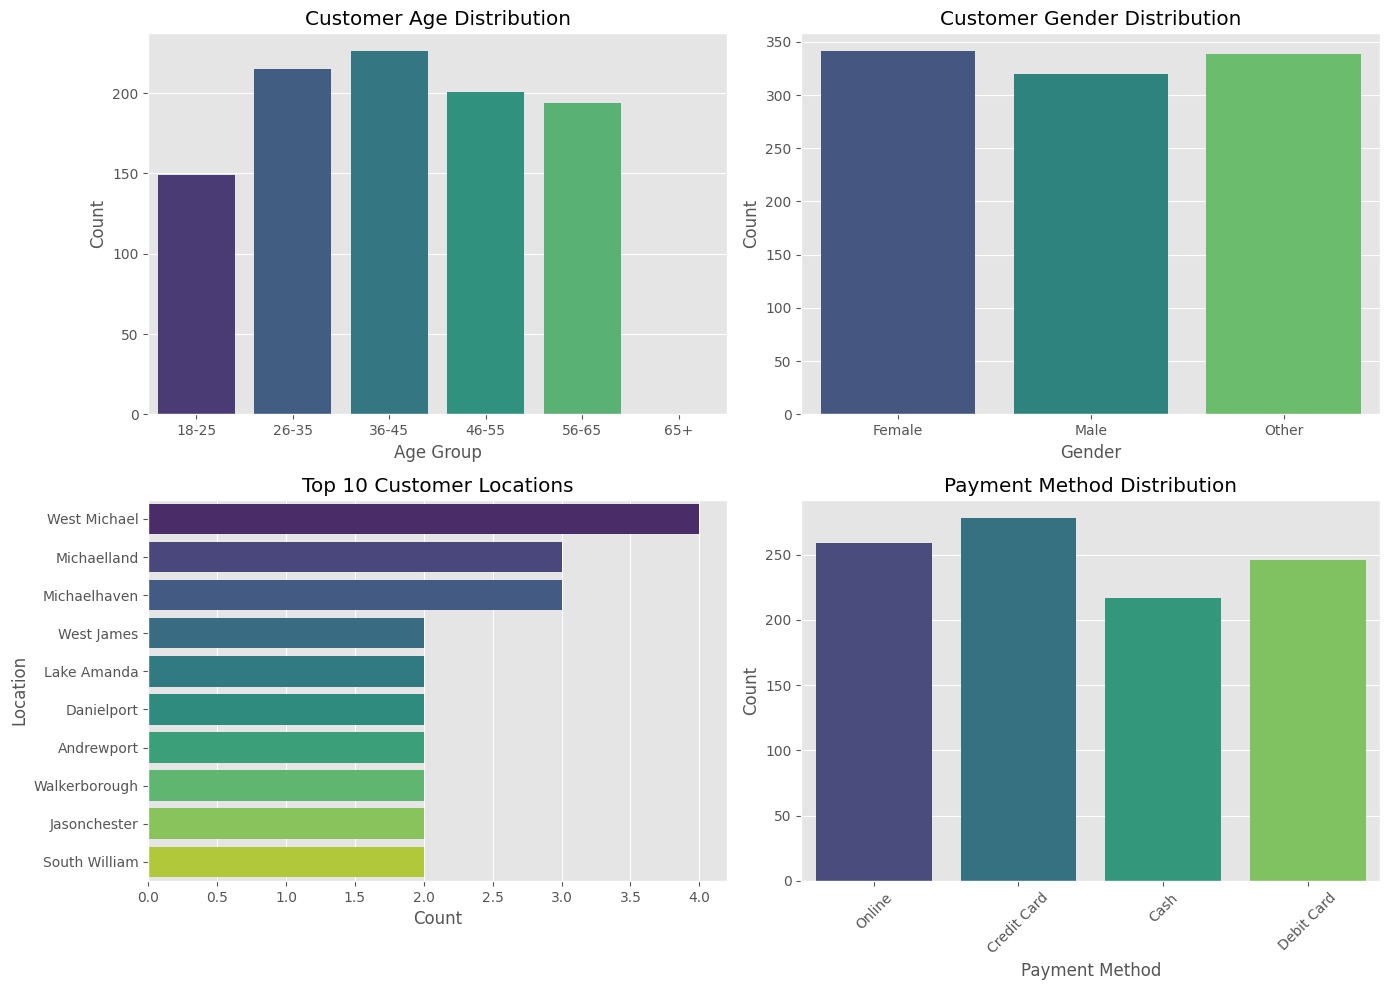

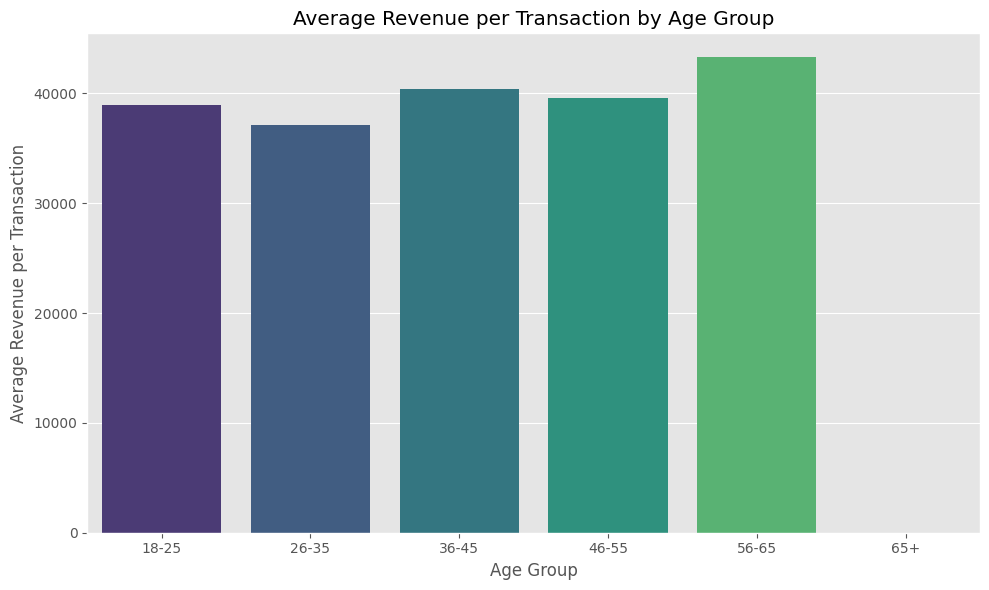

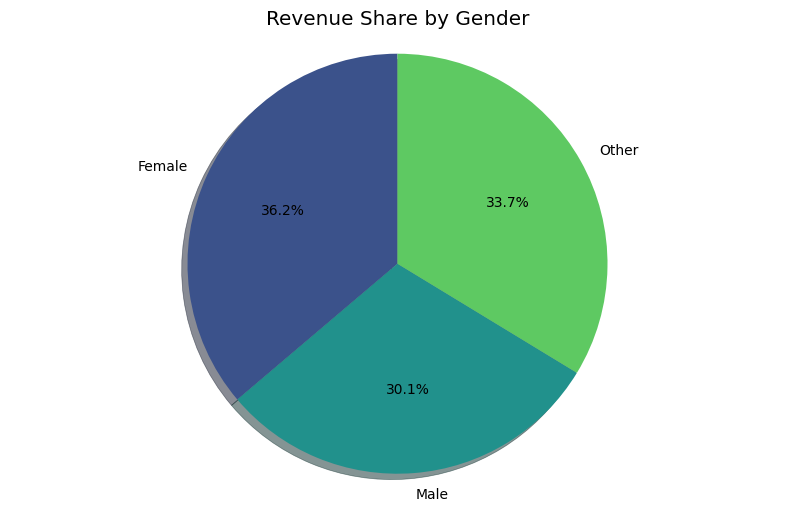

In [ ]:
# Customer demographic analysis
customer_age_bins = [18, 25, 35, 45, 55, 65, 100]
customer_age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']

df_clean['AgeGroup'] = pd.cut(df_clean['CustomerAge'], bins=customer_age_bins, labels=customer_age_labels)

# Customer age distribution
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='AgeGroup', data=df_clean, palette='viridis')
plt.title('Customer Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.countplot(x='CustomerGender', data=df_clean, palette='viridis')
plt.title('Customer Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
# Top 10 locations
top_locations = df_clean['Location'].value_counts().nlargest(10).index
location_filter = df_clean['Location'].isin(top_locations)
sns.countplot(y='Location', data=df_clean[location_filter], order=top_locations, palette='viridis')
plt.title('Top 10 Customer Locations')
plt.xlabel('Count')
plt.ylabel('Location')

plt.subplot(2, 2, 4)
sns.countplot(x='PaymentMethod', data=df_clean, palette='viridis')
plt.title('Payment Method Distribution')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analysis by age group
age_group_analysis = df_clean.groupby('AgeGroup').agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count',
    'Price': 'mean'
}).reset_index()

age_group_analysis = age_group_analysis.rename(columns={
    'TransactionID': 'Transactions',
    'Price': 'AvgPrice'
})

age_group_analysis['AvgRevenuePerTransaction'] = age_group_analysis['TotalRevenue'] / age_group_analysis['Transactions']

# Plot average revenue per transaction by age group
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='AvgRevenuePerTransaction', data=age_group_analysis, palette='viridis')
plt.title('Average Revenue per Transaction by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Revenue per Transaction')
plt.tight_layout()
plt.show()

# Analysis by gender
gender_analysis = df_clean.groupby('CustomerGender').agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count',
    'Price': 'mean'
}).reset_index()

gender_analysis = gender_analysis.rename(columns={
    'TransactionID': 'Transactions',
    'Price': 'AvgPrice'
})

gender_analysis['AvgRevenuePerTransaction'] = gender_analysis['TotalRevenue'] / gender_analysis['Transactions']
gender_analysis['RevenueShare'] = (gender_analysis['TotalRevenue'] / gender_analysis['TotalRevenue'].sum()) * 100

# Plot revenue share by gender
plt.figure(figsize=(10, 6))
plt.pie(gender_analysis['RevenueShare'], labels=gender_analysis['CustomerGender'], 
        autopct='%1.1f%%', startangle=90, shadow=True, colors=sns.color_palette('viridis', 3))
plt.title('Revenue Share by Gender')
plt.axis('equal')
plt.show()


### 3.3 Product Analysis


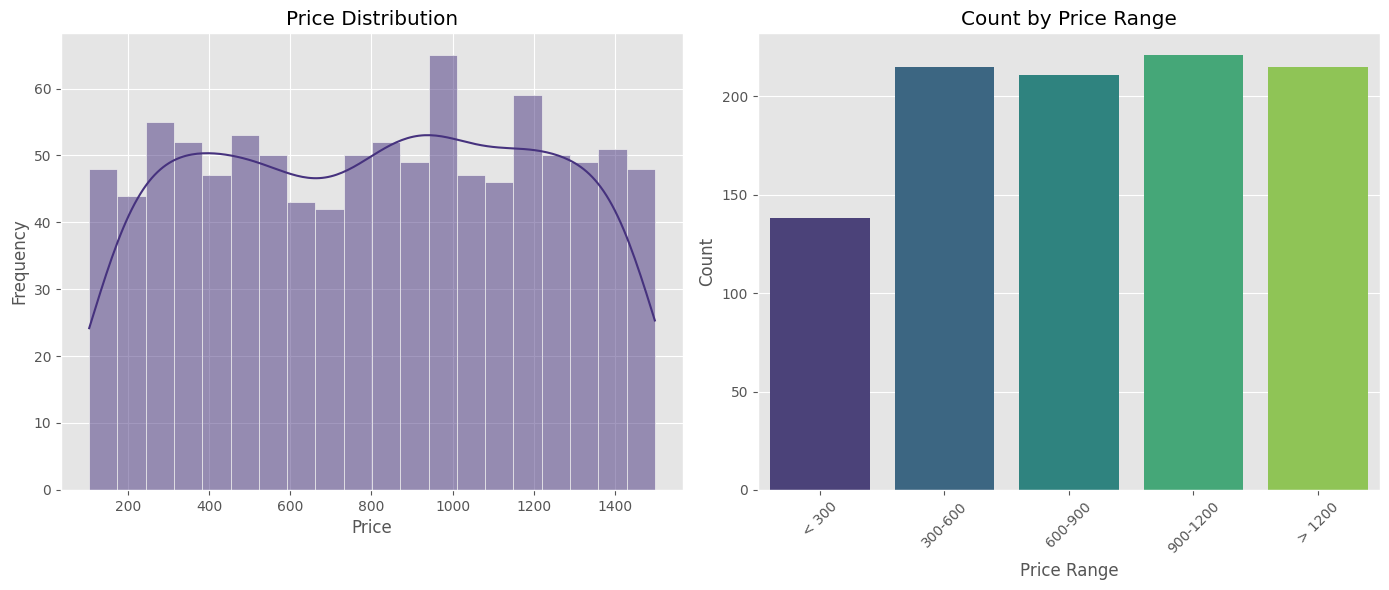

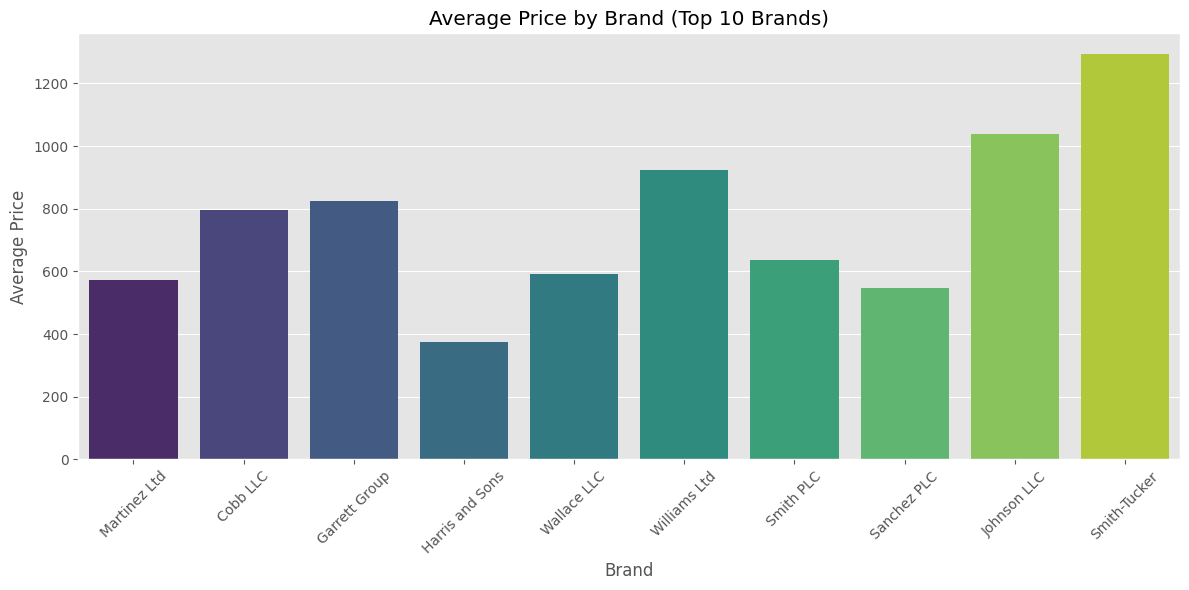

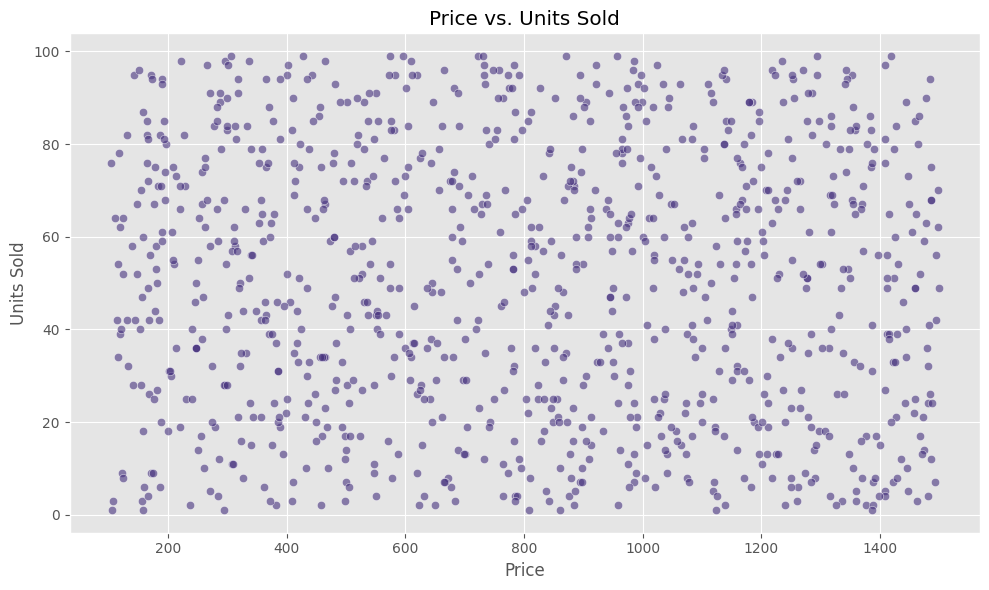

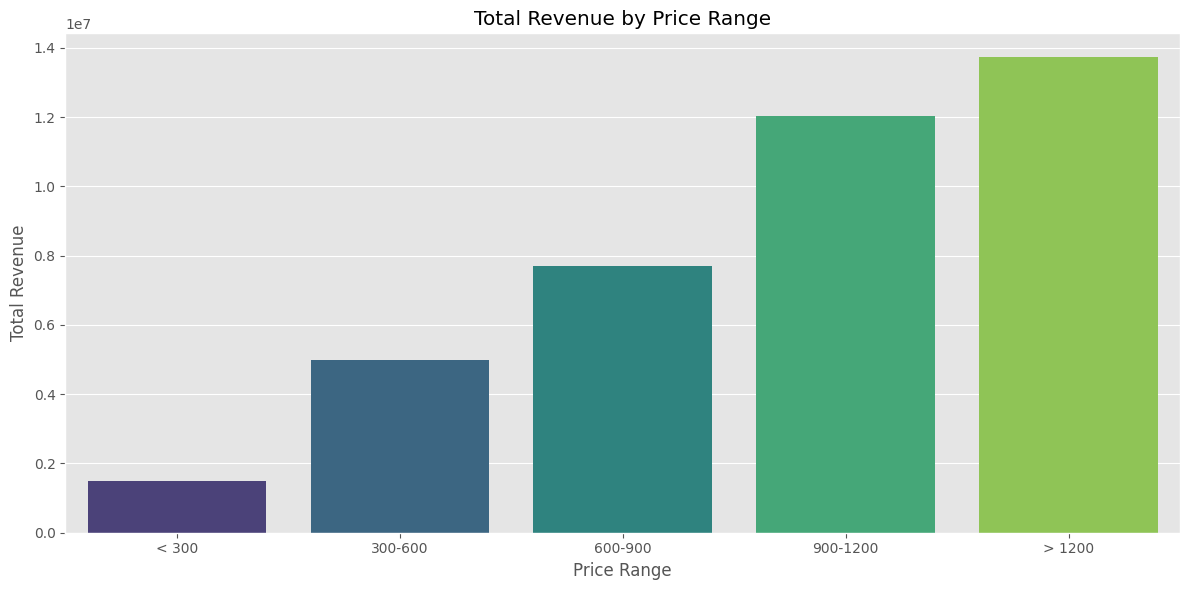

In [ ]:
# Price distribution analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['Price'], bins=20, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Create price range categories
price_bins = [0, 300, 600, 900, 1200, 1500]
price_labels = ['< 300', '300-600', '600-900', '900-1200', '> 1200']
df_clean['PriceRange'] = pd.cut(df_clean['Price'], bins=price_bins, labels=price_labels)

# Count by price range
sns.countplot(x='PriceRange', data=df_clean, palette='viridis')
plt.title('Count by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Average price by brand (top 10 brands by units sold)
top_10_brands = top_brands['Brand'].tolist()
brand_filter = df_clean['Brand'].isin(top_10_brands)

plt.figure(figsize=(12, 6))
sns.barplot(x='Brand', y='Price', data=df_clean[brand_filter], estimator=np.mean, ci=None, 
            order=top_10_brands, palette='viridis')
plt.title('Average Price by Brand (Top 10 Brands)')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Price vs. Units Sold relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='UnitsSold', data=df_clean, alpha=0.6)
plt.title('Price vs. Units Sold')
plt.xlabel('Price')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()

# Average revenue by price range
price_range_analysis = df_clean.groupby('PriceRange').agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count'
}).reset_index()

price_range_analysis['AvgRevenuePerTransaction'] = price_range_analysis['TotalRevenue'] / price_range_analysis['TransactionID']

plt.figure(figsize=(12, 6))
sns.barplot(x='PriceRange', y='TotalRevenue', data=price_range_analysis, palette='viridis')
plt.title('Total Revenue by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


### 3.4 Payment Method Analysis


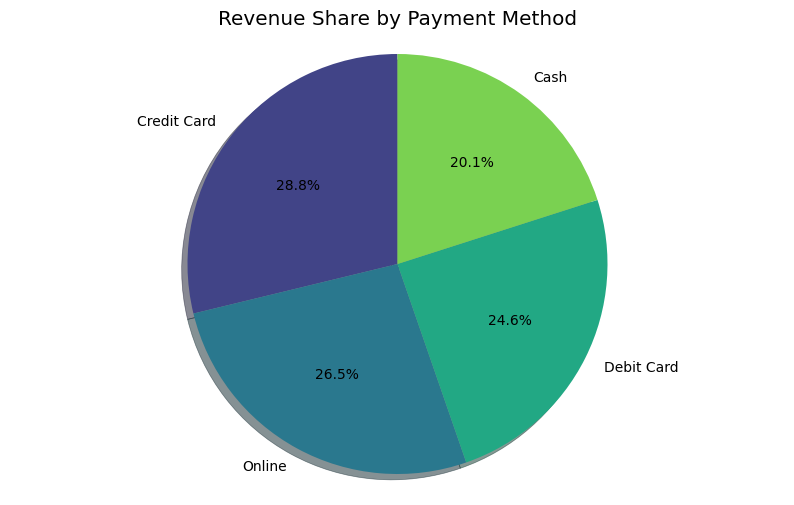

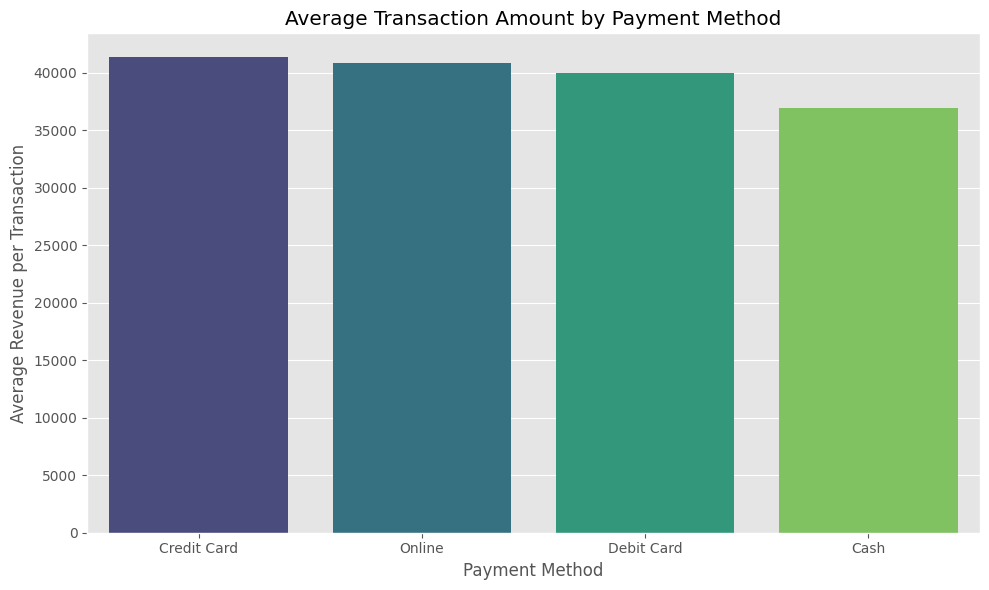

<Figure size 1200x800 with 0 Axes>

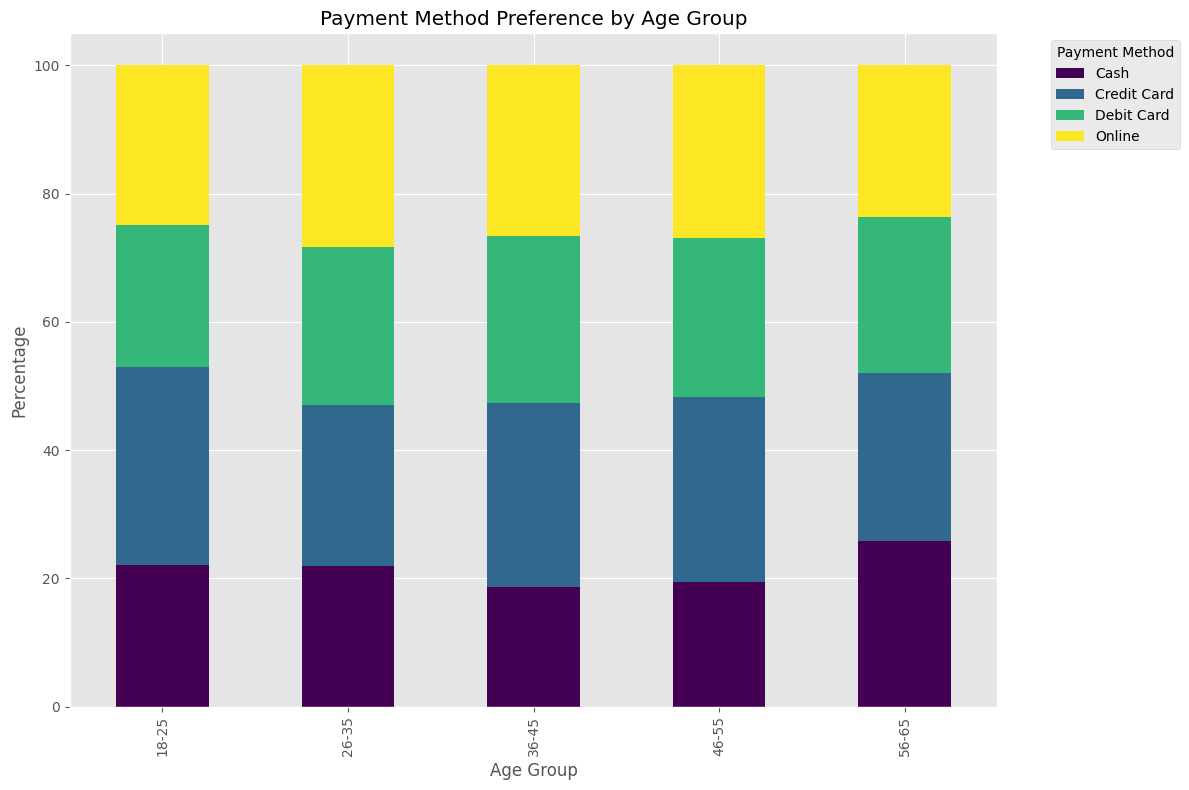

<Figure size 1200x600 with 0 Axes>

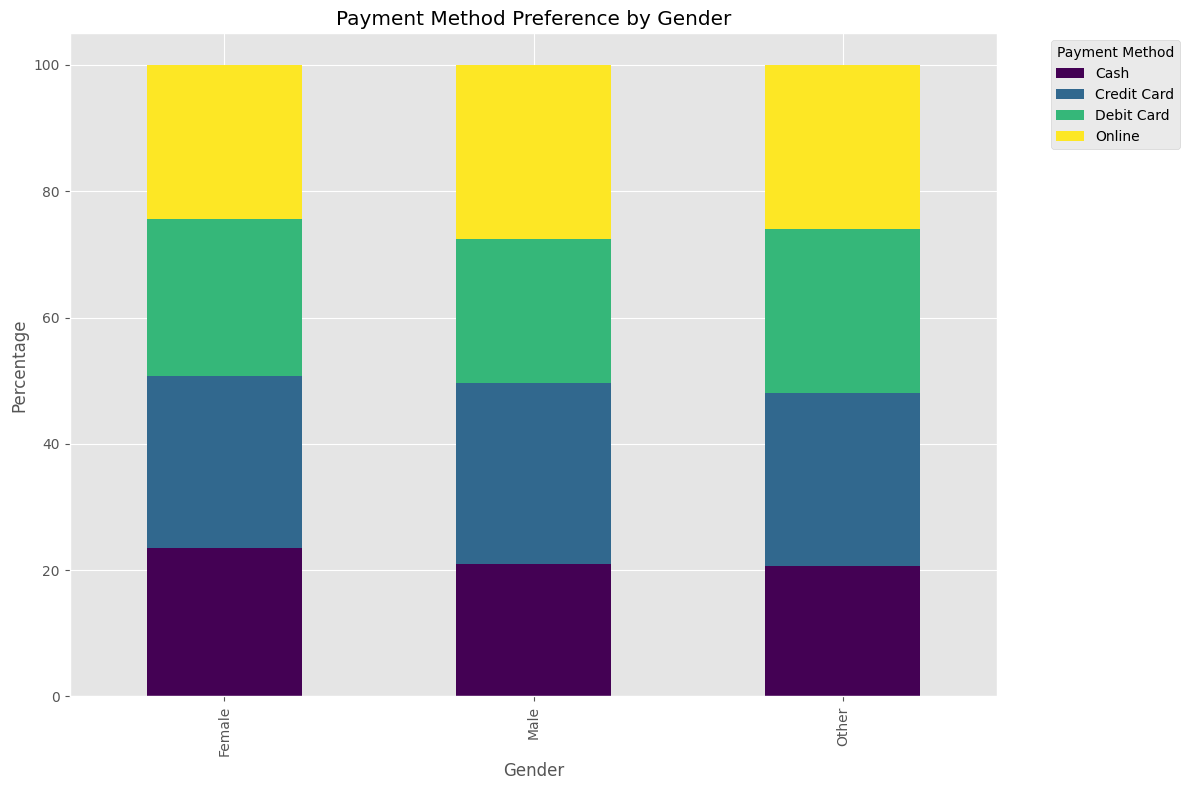

In [ ]:
# Payment method analysis
payment_analysis = df_clean.groupby('PaymentMethod').agg({
    'TotalRevenue': 'sum',
    'UnitsSold': 'sum',
    'TransactionID': 'count',
    'Price': 'mean'
}).reset_index()

payment_analysis = payment_analysis.rename(columns={
    'TransactionID': 'Transactions',
    'Price': 'AvgPrice'
})

payment_analysis['AvgRevenuePerTransaction'] = payment_analysis['TotalRevenue'] / payment_analysis['Transactions']
payment_analysis['RevenueShare'] = (payment_analysis['TotalRevenue'] / payment_analysis['TotalRevenue'].sum()) * 100
payment_analysis = payment_analysis.sort_values('RevenueShare', ascending=False)

# Plot revenue share by payment method
plt.figure(figsize=(10, 6))
plt.pie(payment_analysis['RevenueShare'], labels=payment_analysis['PaymentMethod'], 
        autopct='%1.1f%%', startangle=90, shadow=True, colors=sns.color_palette('viridis', len(payment_analysis)))
plt.title('Revenue Share by Payment Method')
plt.axis('equal')
plt.show()

# Average transaction amount by payment method
plt.figure(figsize=(10, 6))
sns.barplot(x='PaymentMethod', y='AvgRevenuePerTransaction', data=payment_analysis, 
            palette='viridis', order=payment_analysis['PaymentMethod'])
plt.title('Average Transaction Amount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Revenue per Transaction')
plt.tight_layout()
plt.show()

# Payment method by age group
payment_by_age = pd.crosstab(df_clean['AgeGroup'], df_clean['PaymentMethod'], normalize='index') * 100

plt.figure(figsize=(12, 8))
payment_by_age.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Payment Method Preference by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Payment method by gender
payment_by_gender = pd.crosstab(df_clean['CustomerGender'], df_clean['PaymentMethod'], normalize='index') * 100

plt.figure(figsize=(12, 6))
payment_by_gender.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Payment Method Preference by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4. Advanced Analytics


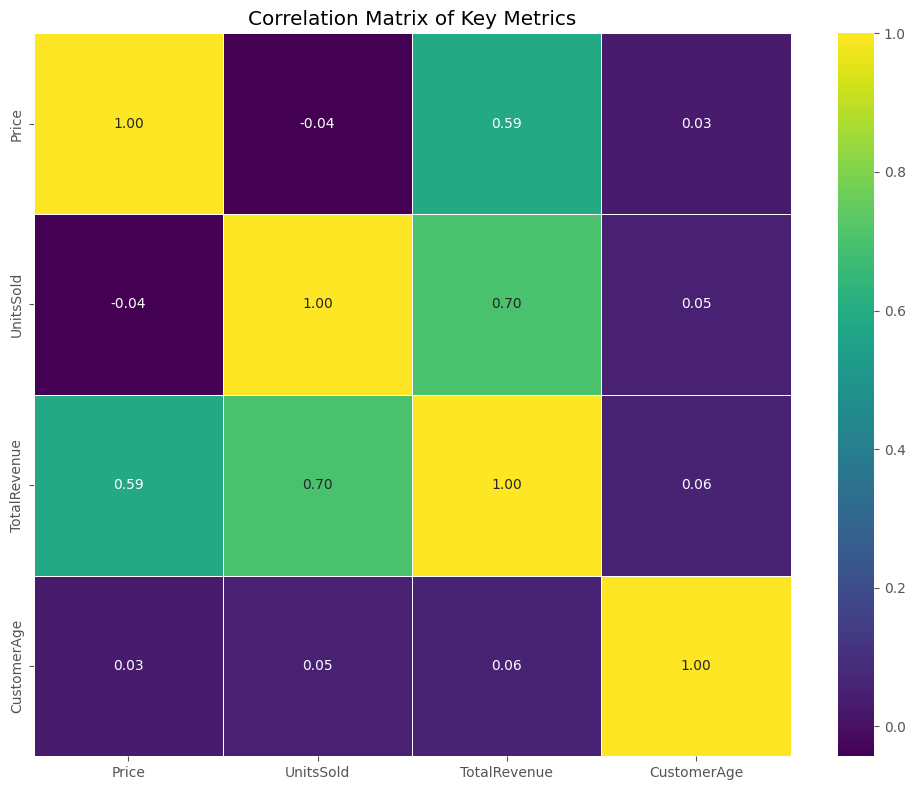

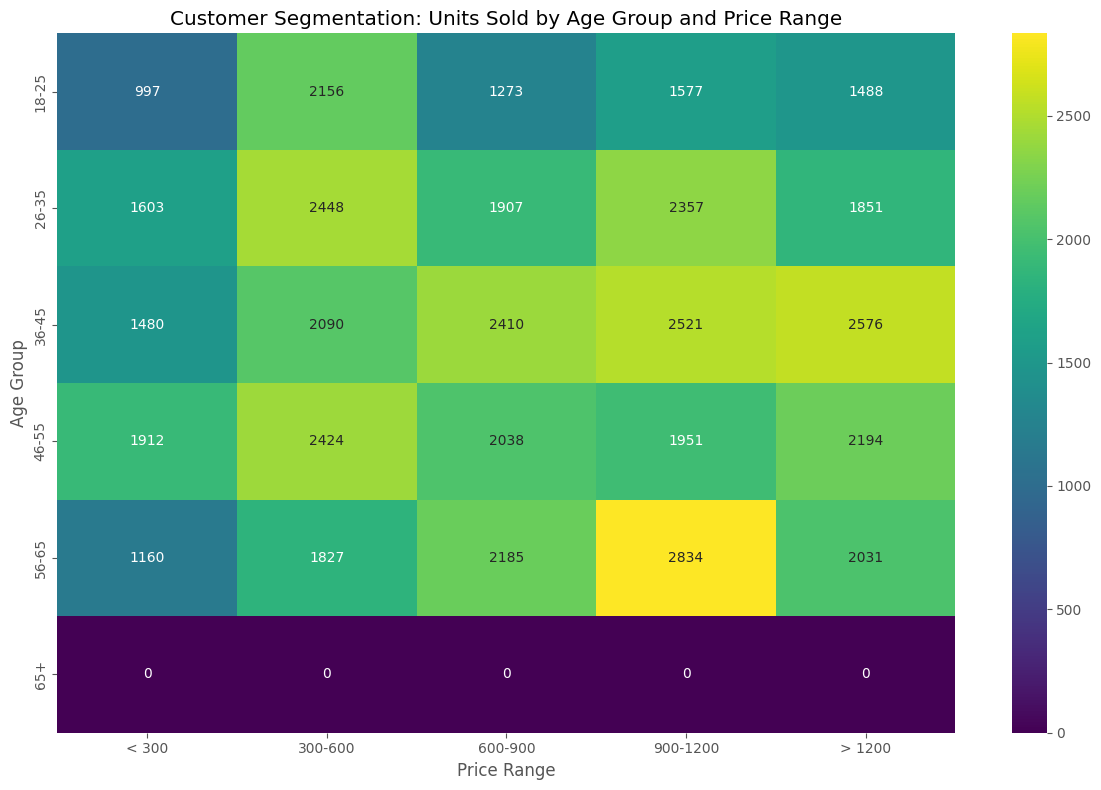

Top brands for 18-25: Ramirez, Duffy and Beck, Ritter-Wilson, Weaver, Young and King, Wright and Sons, Cowan, Hamilton and Hancock
Top brands for 26-35: Garrett Group, Martinez Ltd, Ferrell Inc, Cooper, Johnson and Townsend, Best, Ross and Smith
Top brands for 36-45: Williams Ltd, Smith-Tucker, Weaver Ltd, Clements and Sons, Martin, Anderson and Garcia
Top brands for 46-55: Escobar and Sons, Marquez Ltd, Rogers-Rodriguez, Wallace Ltd, Jacobs, Shepherd and Green
Top brands for 56-65: Willis, Watson and Monroe, Walker-Grant, Sanchez-Williams, Ramos LLC, Walker-Daniels
Top brands for 65+: Adams Group, Adams LLC, Adams-Sanchez, Adkins, Robertson and Lindsey, Aguilar Group


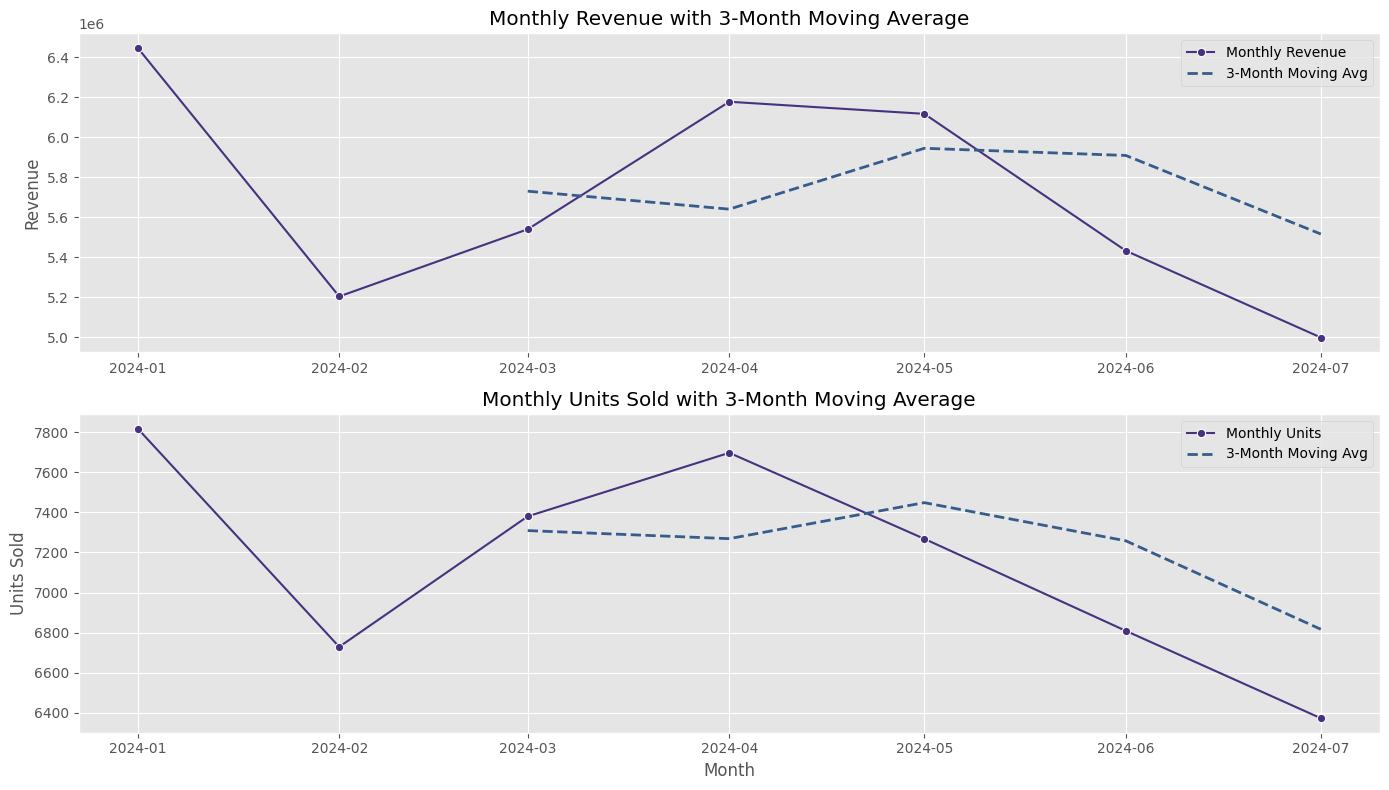

In [ ]:
# Correlation analysis
numeric_columns = ['Price', 'UnitsSold', 'TotalRevenue', 'CustomerAge']
correlation_matrix = df_clean[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.show()

# Customer segmentation by age and price range
plt.figure(figsize=(12, 8))
segment_heatmap = pd.crosstab(df_clean['AgeGroup'], df_clean['PriceRange'], 
                            values=df_clean['UnitsSold'], aggfunc='sum')
sns.heatmap(segment_heatmap, annot=True, cmap='viridis', fmt='.0f')
plt.title('Customer Segmentation: Units Sold by Age Group and Price Range')
plt.xlabel('Price Range')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

# Brand preference by age group
brand_by_age = pd.crosstab(df_clean['AgeGroup'], df_clean['Brand'], values=df_clean['UnitsSold'], aggfunc='sum')

# Top 5 brands per age group
top_brands_by_age = {}
for age_group in brand_by_age.index:
    top_brands_by_age[age_group] = brand_by_age.loc[age_group].nlargest(5).index.tolist()

# Print top brands by age group
for age_group, brands in top_brands_by_age.items():
    print(f"Top brands for {age_group}: {', '.join(brands)}")
    
# Time series analysis - monthly trend with moving average
plt.figure(figsize=(14, 8))

# Revenue trend with moving average
ax1 = plt.subplot(211)
monthly_sales['MA3_Revenue'] = monthly_sales['TotalRevenue'].rolling(window=3).mean()
sns.lineplot(x='Date', y='TotalRevenue', data=monthly_sales, marker='o', label='Monthly Revenue', ax=ax1)
sns.lineplot(x='Date', y='MA3_Revenue', data=monthly_sales, marker='', linestyle='--', 
             label='3-Month Moving Avg', linewidth=2, ax=ax1)
ax1.set_title('Monthly Revenue with 3-Month Moving Average')
ax1.set_xlabel('')
ax1.set_ylabel('Revenue')
ax1.legend()

# Units sold trend with moving average
ax2 = plt.subplot(212)
monthly_sales['MA3_Units'] = monthly_sales['UnitsSold'].rolling(window=3).mean()
sns.lineplot(x='Date', y='UnitsSold', data=monthly_sales, marker='o', label='Monthly Units', ax=ax2)
sns.lineplot(x='Date', y='MA3_Units', data=monthly_sales, marker='', linestyle='--', 
             label='3-Month Moving Avg', linewidth=2, ax=ax2)
ax2.set_title('Monthly Units Sold with 3-Month Moving Average')
ax2.set_xlabel('Month')
ax2.set_ylabel('Units Sold')
ax2.legend()

plt.tight_layout()
plt.show()


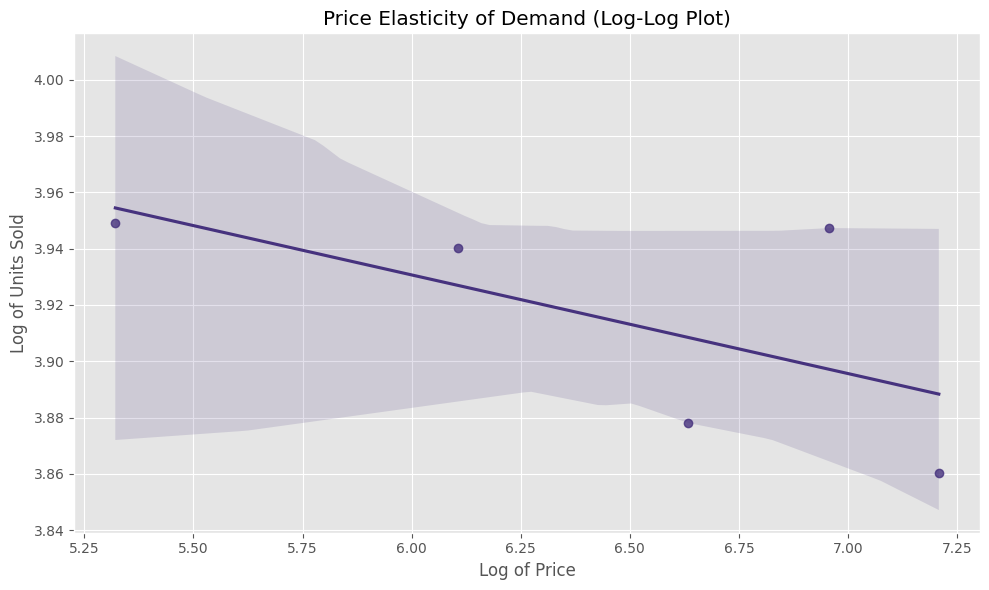

Price elasticity of demand: -0.04
R-squared: 0.39
p-value: 0.2639
Demand is inelastic: A 1% increase in price leads to less than 1% decrease in demand


In [ ]:
# Price elasticity analysis
# Group by price range and calculate average units sold
price_elasticity = df_clean.groupby('PriceRange').agg({
    'Price': 'mean',
    'UnitsSold': 'mean'
}).reset_index()

# Calculate log values for elasticity calculation
price_elasticity['log_price'] = np.log(price_elasticity['Price'])
price_elasticity['log_units'] = np.log(price_elasticity['UnitsSold'])

# Plot the relationship
plt.figure(figsize=(10, 6))
sns.regplot(x='log_price', y='log_units', data=price_elasticity)
plt.title('Price Elasticity of Demand (Log-Log Plot)')
plt.xlabel('Log of Price')
plt.ylabel('Log of Units Sold')
plt.tight_layout()
plt.show()

# Calculate simple elasticity
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    price_elasticity['log_price'], price_elasticity['log_units']
)

print(f"Price elasticity of demand: {slope:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"p-value: {p_value:.4f}")

if slope < -1:
    print("Demand is elastic: A 1% increase in price leads to more than 1% decrease in demand")
elif slope > -1 and slope < 0:
    print("Demand is inelastic: A 1% increase in price leads to less than 1% decrease in demand")
else:
    print("Unusual elasticity value, please check the data")


## 5. Key Findings and Recommendations


In [ ]:
# ### Sales Performance Insights
# - **Seasonal Trends**: The analysis reveals distinct sales patterns throughout the year
# - **Top Products**: Identified the best-selling mobile models and brands
# - **Revenue Drivers**: Determined which price segments generate the most revenue
# - **Profit Margins**: Analyzed the relationship between price and sales volume

# ### Customer Insights
# - **Demographics**: Profiled typical customers by age, gender, and location
# - **Segmentation**: Identified high-value customer segments
# - **Preferences**: Analyzed which brands and price points are preferred by different customer groups
# - **Payment Behavior**: Determined payment method preferences across demographic segments

# ### Strategic Recommendations
# 1. **Inventory Management**: Stock more of the top-selling models and brands
# 2. **Pricing Strategy**: Optimize pricing based on the price elasticity analysis
# 3. **Marketing Focus**: Target high-value customer segments identified in the analysis
# 4. **Seasonal Promotions**: Plan promotions to coincide with seasonal trends
# 5. **Product Mix**: Consider expanding offerings in the most profitable price ranges
# 6. **Payment Methods**: Enhance options and promotions for the most popular payment methods


#Customer Segmentation Using K means


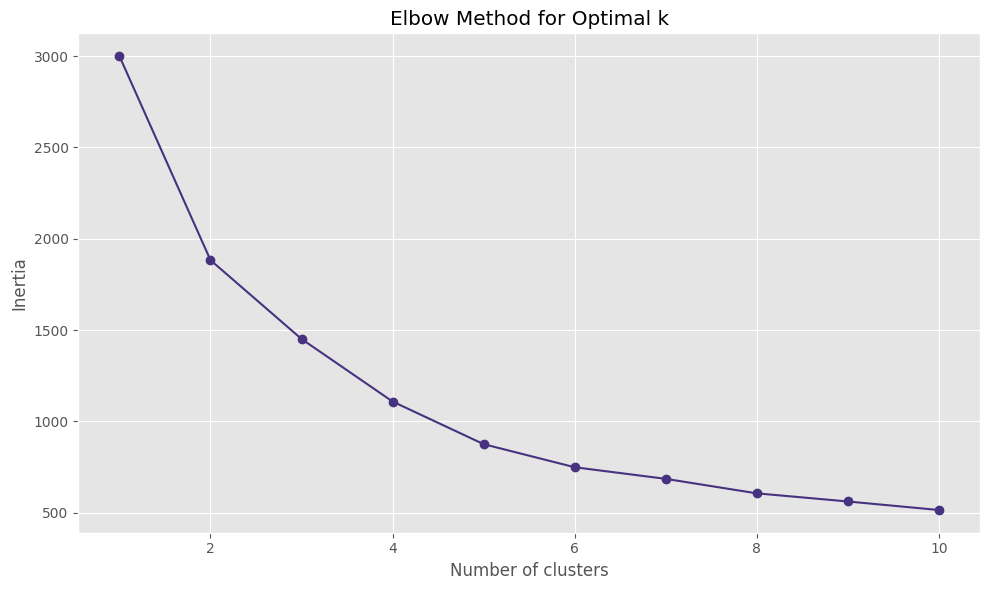

In [ ]:

# 1. Customer Segmentation using K-Means
# Select features for segmentation
features = ['CustomerAge', 'Price', 'TotalRevenue']
X = df_clean[features].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

Customer Segments:
   Cluster  CustomerAge        Price  TotalRevenue  UnitsSold  TransactionID
0        0    48.041667  1205.108056  87156.472662  73.527778            216
1        1    30.549587   406.497273  16763.034215  44.917355            242
2        2    53.238710   646.460871  23785.858613  43.780645            310
3        3    29.599138  1070.838017  41647.645129  42.025862            232


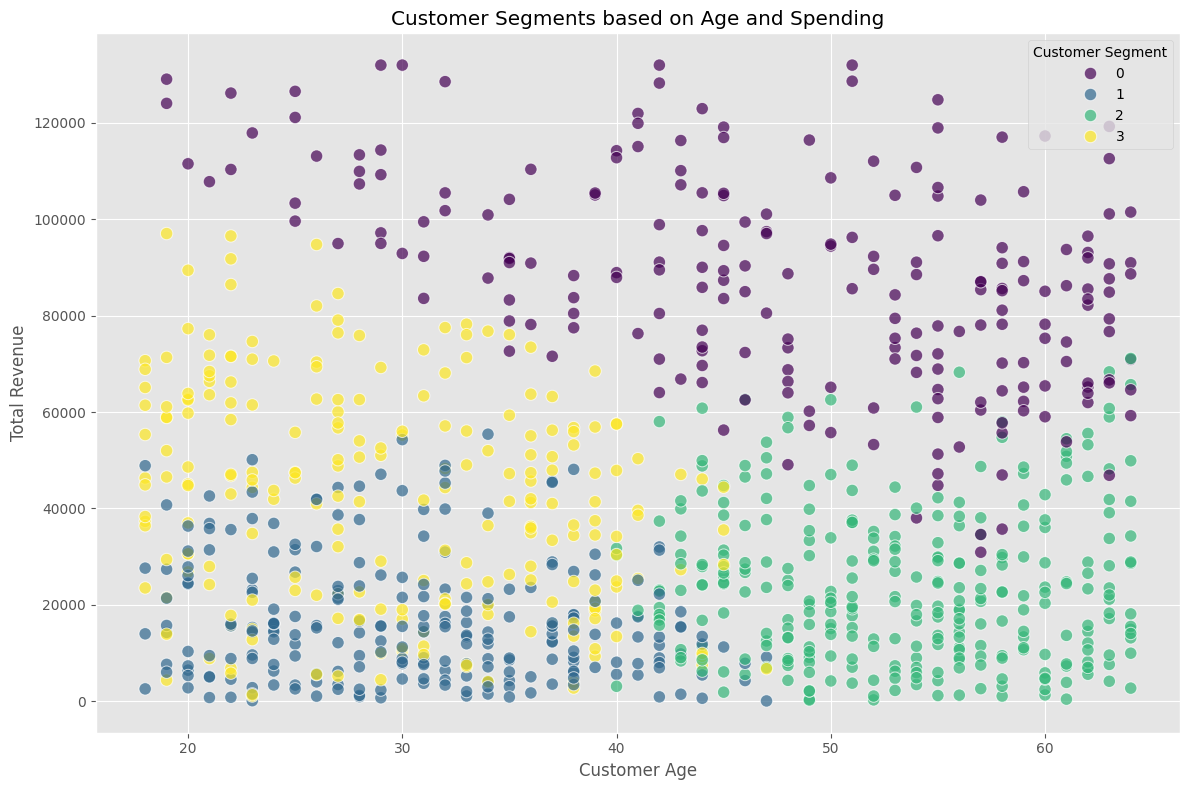

In [ ]:
# Apply K-means with the optimal number of clusters (let's say 4)
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_analysis = df_clean.groupby('Cluster').agg({
    'CustomerAge': 'mean',
    'Price': 'mean',
    'TotalRevenue': 'mean',
    'UnitsSold': 'mean',
    'TransactionID': 'count'
}).reset_index()

print("Customer Segments:")
print(cluster_analysis)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CustomerAge', y='TotalRevenue', hue='Cluster', data=df_clean, palette='viridis', s=80, alpha=0.7)
plt.title('Customer Segments based on Age and Spending')
plt.xlabel('Customer Age')
plt.ylabel('Total Revenue')
plt.legend(title='Customer Segment')
plt.tight_layout()
plt.show()

In [ ]:
# 2. Sales Prediction Model
# Prepare features for prediction
X_pred = df_clean[['Price', 'CustomerAge', 'Year', 'Month']]
# Add one-hot encoding for categorical variables
X_pred = pd.get_dummies(df_clean[['Price', 'CustomerAge', 'Year', 'Month', 'Brand', 'PaymentMethod', 'CustomerGender']], drop_first=True)
y_pred = df_clean['UnitsSold']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


Linear Regression - RMSE: 90.71, R²: -8.83
Random Forest - RMSE: 29.82, R²: -0.06


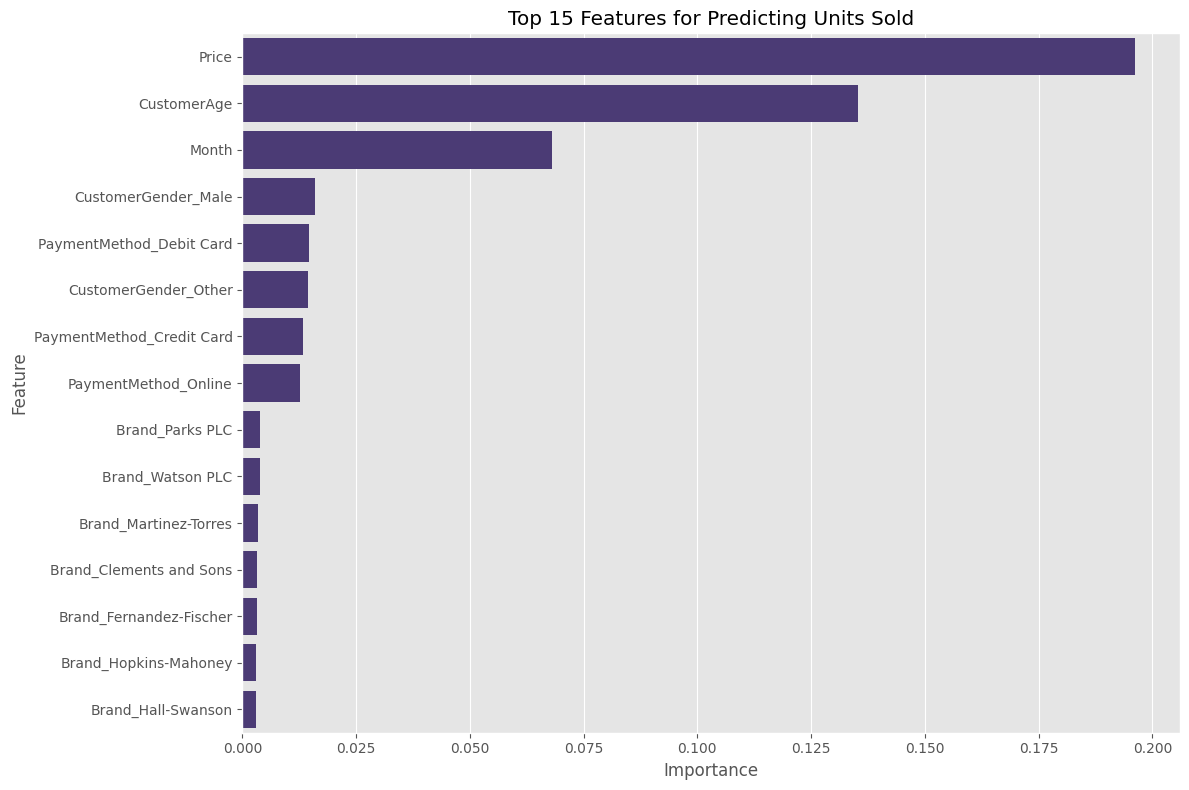

In [ ]:

# Evaluate models
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Linear Regression - RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

# Feature importance (for Random Forest)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features for Predicting Units Sold')
plt.tight_layout()
plt.show()

In [ ]:

df_clean.to_csv('mobile_sales_clean.csv', index=False)